## Data loading

# Load Data
We will load all the data except 219 V columns that were determined redundant by correlation analysis [here][1]

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

In [29]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [31]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
Y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: total: 11.5 s
Wall time: 18.9 s


# Normalize D Columns
The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is `D15n = Transaction_Day - D15` and `Transaction_Day = TransactionDT/(24*60*60)`. Afterward we multiple this number by negative one.

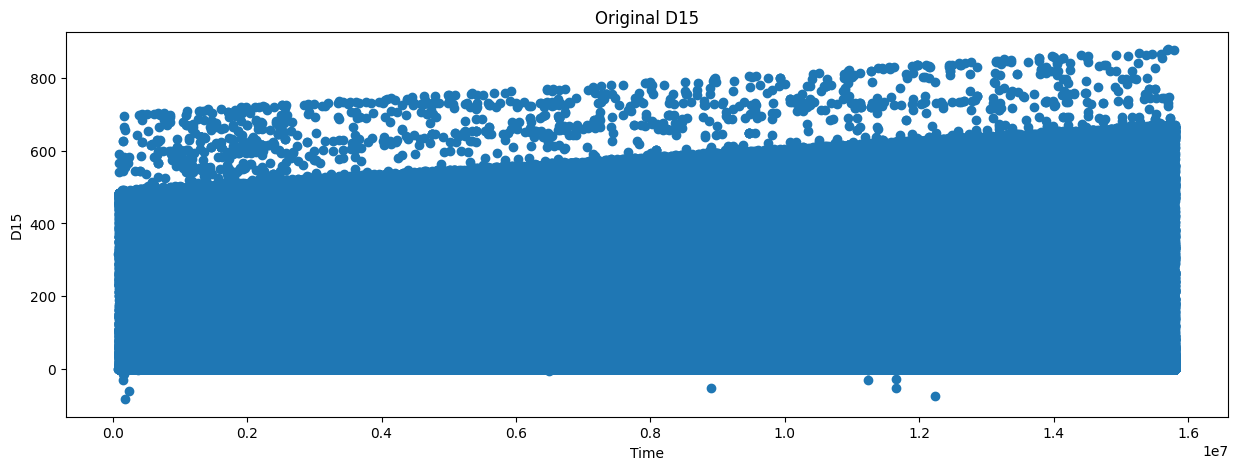

In [32]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [33]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

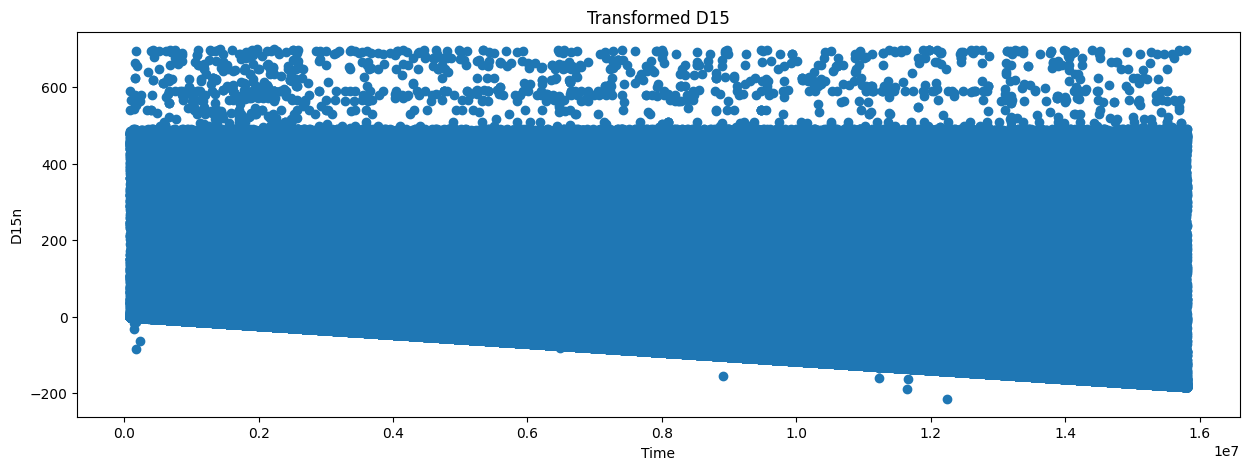

In [34]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [35]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str_(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

<timed exec>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<timed exec>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, t

CPU times: total: 1.59 s
Wall time: 2.36 s


# Encoding Functions
Below are 5 encoding functions. (1) `encode_FE` does frequency encoding where it combines train and test first and then encodes. (2) `encode_LE` is a label encoded for categorical features (3) `encode_AG` makes aggregated features such as aggregated mean and std (4) `encode_CB` combines two columns (5) `encode_AG2` makes aggregated features where it counts how many unique values of one feature is within a group. For more explanation about feature engineering, see the discussion [here][1]

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-641841

In [36]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

# Feature Engineering
We will now engineer features. All of these features where chosen because each increases local validation. The procedure for engineering features is as follows. First you think of an idea and create a new feature. Then you add it to your model and evaluate whether local validation AUC increases or decreases. If AUC increases keep the feature, otherwise discard the feature.

In [37]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , 

<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\ADMIN\AppData\Local\Temp\ipykerne

card3_FE , P_emaildomain_FE , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1 , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str)


card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[nm] = df1[col].map(vc)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[nm] = df2[col].map(vc)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'TransactionAmt_card1_addr1_P_emaildomain_mean' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignme

'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: total: 2.64 s
Wall time: 4.61 s


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8068\2377275247.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trai

# Feature Selection - Time Consistency
We added 28 new feature above. We have already removed 219 V Columns from correlation analysis done [here][1]. So we currently have 242 features now. We will now check each of our 242 for "time consistency". We will build 242 models. Each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above `AUC = 0.5`. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN. More techniques for feature selection are listed [here][2]

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In [38]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [39]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

In [40]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [41]:
x_train, y_train = X_train.loc[idxT,cols], Y_train[idxT]
x_test, y_test = X_train.loc[idxV,cols], Y_train[idxV]

## Data preprocessing

Because we need our data to be in the range$[-1,1]$ at the beginning, we will create a preprocessing pipeline using sklearn Pipelines. 

It will apply a LabelEncoder on categorical columns, before using it in a MinMaxScaler.

In [42]:
import sys
sys.path.insert(0, r'cryptotree')
from preprocessing import Featurizer

Now that we have defined the featurizer, we can use it on our dataset.

In [43]:
categorical_columns = ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6',
       'M7', 'M8', 'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13',
       'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37',
       'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62',
       'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86',
       'V88', 'V89', 'V91', 'V107', 'V108', 'V111', 'V115', 'V117',
       'V120', 'V121', 'V123', 'V124', 'V127', 'V129', 'V130', 'V136',
       'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165',
       'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180',
       'V182', 'V185', 'V187', 'V188', 'V198', 'V203', 'V205', 'V207',
       'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224',
       'V226', 'V228', 'V229', 'V234', 'V235', 'V238', 'V240', 'V250',
       'V252', 'V253', 'V257', 'V258', 'V260', 'V261', 'V264', 'V266',
       'V267', 'V271', 'V274', 'V277', 'V281', 'V283', 'V284', 'V285',
       'V286', 'V289', 'V291', 'V294', 'V296', 'V297', 'V301', 'V303',
       'V305', 'V307', 'V309', 'V310', 'V314', 'V320', 'id_01', 'id_02',
       'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
       'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23',
       'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
       'id_38', 'DeviceType', 'DeviceInfo', 'cents', 'addr1_FE',
       'card1_FE', 'card2_FE', 'card3_FE', 'P_emaildomain_FE',
       'card1_addr1', 'card1_addr1_P_emaildomain', 'card1_addr1_FE',
       'card1_addr1_P_emaildomain_FE', 'TransactionAmt_card1_mean',
       'TransactionAmt_card1_std', 'TransactionAmt_card1_addr1_mean',
       'TransactionAmt_card1_addr1_std',
       'TransactionAmt_card1_addr1_P_emaildomain_mean',
       'TransactionAmt_card1_addr1_P_emaildomain_std', 'D9_card1_mean',
       'D9_card1_std', 'D9_card1_addr1_mean', 'D9_card1_addr1_std',
       'D9_card1_addr1_P_emaildomain_mean',
       'D9_card1_addr1_P_emaildomain_std', 'D11_card1_mean',
       'D11_card1_std', 'D11_card1_addr1_mean', 'D11_card1_addr1_std',
       'D11_card1_addr1_P_emaildomain_mean',
       'D11_card1_addr1_P_emaildomain_std']

pipe = Featurizer(categorical_columns)

In [44]:
X_train_normalized = pipe.fit_transform(x_train)

We can have a look and check that input is in $[-1,1]$.

In [45]:
X_train_normalized[:2]

array([[2.74634717e-01, 1.00000000e+00, 7.42790772e-01, 0.00000000e+00,
        3.86792453e-01, 3.42342342e-01, 5.00000000e-01, 5.01557632e-01,
        8.84057971e-01, 7.77604977e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.34517766e-04, 9.28505107e-04, 0.00000000e+00,
        0.00000000e+00, 7.78210117e-04, 0.00000000e+00, 0.00000000e+00,
        4.95049505e-03, 0.00000000e+00, 1.42045455e-03, 0.00000000e+00,
        6.31313131e-04, 9.21658986e-04, 2.34009360e-02, 0.00000000e+00,
        2.32172471e-02, 0.00000000e+00, 0.00000000e+00, 6.31320223e-01,
        5.77198104e-01, 5.21529755e-01, 5.00000000e-01, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.85714286e-01,
        3.33333333e-01, 2.85714286e-01, 2.85714286e-01, 2.00000000e-01,
        2.85714286e-01, 1.00000000e+00, 6.25000000e-02, 1.33333333e-01,
        1.42857143e-01, 1.53846154e-01, 2.50000000e-01, 1.250000

## Neural Random Forest

Now that data has been preprocessed, we can feed it to a Neural Random Forest.

Here we can have a look at the activation function we will use, for instance sigmoid.

D:\UIT\Sophomore\HK2\Cryptography\ieee-fraud-detection\SEAL-Python\cryptotree\polynomials.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 1 Axes>, <Axes: >)

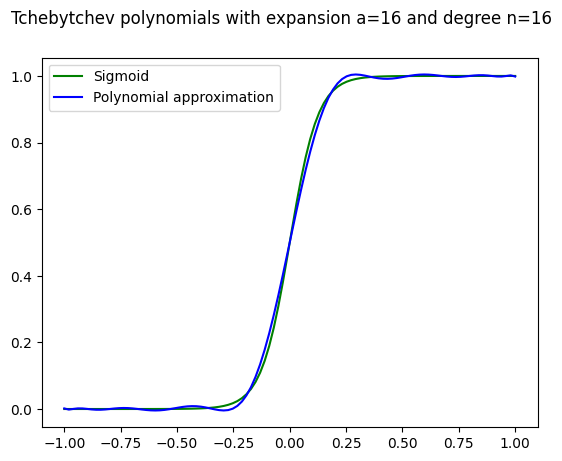

In [46]:
import torch
import numpy as np

from tree import NeuralRandomForest, SigmoidTreeMaker, TanhTreeMaker
from polynomials import plot_graph_function_approximation

max_depth = 4

dilatation_factor = 16
polynomial_degree = dilatation_factor

plot_graph_function_approximation(torch.sigmoid,
                                  dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

Now that we have te parameters of dilation and polynomial degree for the activation functions, we can create the tree makers.

In [47]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

We can fit a regular sklearn Random Forest now.

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

From the regular RF, we can define the Neural Random Forest, with sigmoid and tanh activations.

### Without finetuning

In [49]:
estimators = rf.estimators_

In [50]:
sigmoid_neural_rf = NeuralRandomForest(estimators, sigmoid_tree_maker)
tanh_neural_rf = NeuralRandomForest(estimators, tanh_tree_maker)

In [51]:
with torch.no_grad():
    sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

pred = rf.predict(X_train_normalized)
print(f"Original accuracy : {(pred == y_train).mean()}")
    
print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_train).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_train).mean()}")

print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")

Original accuracy : 0.9696729546968311
Accuracy of sigmoid  : 0.035138460843747533
Accuracy of tanh : 0.9648773438999334
Match between sigmoid and original : 0.005416511441505515
Match between tanh and original : 0.9945992933021754


We can see that there is a discrepancy between the original Random Forest and the neural ones, especially for the sigmoid one.

Nonetheless we can correct this error by finetuning the final layer of our neural networks to take into account the fact that due to using activation functions not sharp enough.

### With finetuning

Because we need to make sure that at each step of the Neural Network the output is in $[-1,1]$, to be able to use the polynomial approximation of the activation, we can only safely train the last layer.

To do so we will use Pytorch and [fastai](https://github.com/fastai/fastai).

Here we first define our Pytorch Dataset.

In [52]:
from torch.utils import data
import numpy as np

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
    
        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

Then we create the Pytorch dataloaders.

In [53]:
from sklearn.model_selection import train_test_split

x_train, y_train = X_train.loc[idxT,cols], Y_train[idxT]
x_test, y_test = X_train.loc[idxV,cols], Y_train[idxV]

X_train_normalized, X_valid_normalized, y_train, y_valid = train_test_split(pipe.transform(x_train), 
                                                                            y_train,
                                                                            train_size=0.8)

In [54]:
train_ds = TabularDataset(X_train_normalized, y_train.values)
valid_ds = TabularDataset(X_valid_normalized, y_valid.values)

In [55]:
bs = 128

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

Here we will just define the model, which is a sigmoid Neural Random Forest.

In [56]:
tree_maker = sigmoid_tree_maker

model = NeuralRandomForest(rf.estimators_, tree_maker=tree_maker)

Because we only want to train the last layer, we will freeze the first two layers and check they are frozen.

In [57]:
model.freeze_layer("comparator")
model.freeze_layer("matcher")

for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([216, 15, 100]) False
torch.Size([15, 100]) False
torch.Size([16, 15, 100]) False
torch.Size([16, 100]) False
torch.Size([2, 16, 100]) True
torch.Size([2, 100]) True


In [58]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.9696746480622256
Accuracy : 0.035123220555198065
Same output : 0.005379257402829049


Now we can define our fastai Learner, with the dataset, the model, and the loss function, which is a Label Smoothing Cross Entropy here.

In [59]:
from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from tree import CrossEntropyLabelSmoothing
import torch.nn as nn

data = DataBunch(train_dl, valid_dl,fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, model, loss_func=criterion, metrics=accuracy)

We will use fastai lr finder to have an idea of what learning rate to choose.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


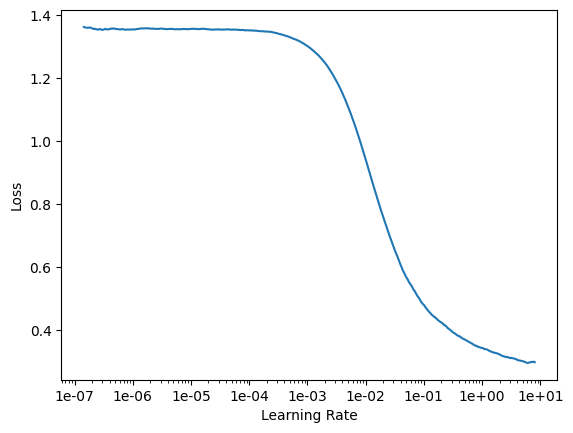

In [60]:
learn.lr_find(num_it=500)
learn.recorder.plot()

Here we can see that a good learning rate should be around 1e+1.

We can now fine tune our model.

In [61]:
learn.fit_one_cycle(5,1e+1/2)

epoch,train_loss,valid_loss,accuracy,time
0,1.561236,1.445621,0.964801,00:39
1,1.854112,3.004255,0.964801,00:40
2,0.489869,0.276640,0.965647,00:39
3,0.288870,0.290156,0.965105,00:39
4,0.266775,0.266831,0.967792,00:40


Here we can have a look at the performance of the Neural Random Forest tuned with respect to the original sklearn Random Forest.

In [65]:
import pickle
pred = rf.predict(X_valid_normalized)
with torch.no_grad():
    neural_pred = model(torch.tensor(X_valid_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

pickle.dump(model, open("model.pkl", "wb")) #NRF 

Original accuracy : 0.9696661812352536
Accuracy : 0.9677921901988011
Same output : 0.9971325679321751


## Homomorphic Random Forest

Now that we have seen how a Neural Random Forest can be obtained and fine tuned from a regular sklearn Random Forest, we can now see how its Homomorphic Random Forest counterpart performs.

To do so, we must first initialize the parameters of the CKKS SEAL library, and choose the polynomial activation function we want. Here we will use the same activation function as the above Neural Random Forest.

In [18]:
import numpy as np 

dilatation_factor = 16
degree = dilatation_factor

PRECISION_BITS = 28
UPPER_BITS = 9

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 3

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 16384

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]
438


Now we just need to use the parameters defined above to populate our environment with SEAL context.

In [19]:
from seal_helper import create_seal_globals, append_globals_to_builtins
import builtins

create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS, use_symmetric_key=False)
append_globals_to_builtins(globals(), builtins)

We can then create our Homomorphic Random Forest from the Neural Random Forest we fine tuned earlier.

We first have to extract the weights using the Homomorphic Random Forest class, and pass it to the Homomorphic Tree Evaluator which will do the computation, using the polynomial activation given, and the SEAL context.

A featurizer is also created for the client side, in order to preprocess, encode and encrypt the data.

In [32]:
from cryptoTree import HomomorphicNeuralRandomForest, HomomorphicTreeEvaluator, HomomorphicTreeFeaturizer
from polynomials import polyeval_tree

h_rf = HomomorphicNeuralRandomForest(model)

tree_evaluator = HomomorphicTreeEvaluator.from_model(h_rf, tanh_tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

homomorphic_featurizer = HomomorphicTreeFeaturizer(h_rf.return_comparator(), encoder, encryptor, scale)

Now we can take some data, encrypt it, and pass it to our Homorphic Tree Evaluator : 

In [33]:
i = 0

x = X_train_normalized[i]
ctx = homomorphic_featurizer.encrypt(x)

# outputs = tree_evaluator(ctx)

We can decrypt and decode the data to see the output :

In [78]:
import seal

ptx = seal.Plaintext()
decryptor.decrypt(outputs, ptx)

homomorphic_pred = encoder.decode(ptx)[:2]

We can see what was the original output, if we had used only the Neural Random Forest : 

In [79]:
x = X_train_normalized[i]

pred = rf.predict_proba(x.reshape(1,-1))
neural_pred = model(torch.tensor(x).float().unsqueeze(0))

print(f"Original Random Forest output : {pred}")
print(f"Neural Random Forest output : {neural_pred.detach()}")
print(f"Homomorphic Random Forest output : {homomorphic_pred}")

Original Random Forest output : [[0.983095 0.016905]]
Neural Random Forest output : tensor([[1.5006, 0.6840]])
Homomorphic Random Forest output : [1.473423 0.669871]


Here we can see our Neural Random Forest, and Homomorphic Random Forest have very similar outputs.

## Comparison between models

We will now compare a linear model, a RF, a NRF and a HRF. 

Because computation are done one at a time with HRF, we will use Fastai `parallel` to speedup inference taking advantage of the multiple CPUs.

We compute the predictions of the NRF.

In [73]:
hrf_pred = np.load("hrf_pred.npy")

In [74]:
outputs = []

for x,y in valid_dl:
    with torch.no_grad():
        pred = model(x)
    outputs.append(pred)
    
nrf_pred = torch.cat(outputs).argmax(dim=1).numpy()

Finally we compute the predictions of logistic regression and RF.

In [75]:
from sklearn.linear_model import LogisticRegression

linear = LogisticRegression()
linear.fit(X_train_normalized, y_train)

# We compute the linear preds
linear_pred = linear.predict(X_valid_normalized)

# We compute the random forest predictions
rf_pred = rf.predict(X_valid_normalized)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can compute all metrics now.

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred, y):
    """Computes all the metrics between predictions and real values"""
    accuracy = accuracy_score(pred,y)
    precision = precision_score(pred,y)
    recall = recall_score(pred,y)
    f1 = f1_score(pred, y)
    return dict(accuracy=accuracy, precision=precision, recall=recall, f1=f1)

models = dict(nrf=nrf_pred, hrf=hrf_pred, rf=rf_pred, linear=linear_pred)

outputs = []
for name, pred in models.items():
    metrics = compute_metrics(pred, y_valid)
    metrics["model"] = name
    outputs.append(metrics)

In [77]:
outputs = pd.DataFrame(outputs)

In [78]:
outputs

,accuracy,precision,recall,f1,model
0,0.967792,0.090763,0.940199,0.165545,nrf
1,0.961188,0.002886,0.026627,0.005208,hrf
2,0.969666,0.148172,0.937120,0.255885,rf
3,0.969847,0.198525,0.782554,0.316705,linear


In [79]:
outputs.to_csv("results.csv", index = None)

Finally we can have a look at how similar NRF and HRF predictions are.

In [80]:
(nrf_pred == hrf_pred).mean()

0.9928088416251792